In [1]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle

In [2]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [3]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_70_30.csv')
data_val = pd.read_csv('../../Data Splits/val_data_70_30.csv')

In [4]:
X_train = data_train['article']
y_train = data_train['label']

X_val = data_val['article']
y_val = data_val['label']

In [5]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess(text) for text in X]

    def preprocess(self, text):
        # print(textes)
        text = str(text)
        text = text.lower()
        normalized = unicodedata.normalize("NFD", text)
        text = "".join(c for c in normalized if unicodedata.category(c) != "Mn")
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)
        return text

In [6]:
#create StopWords
stopwords = pd.read_json('../../Datasets/stopwords-tl.json')
custom_stop_words = stopwords[0].values.tolist()

In [7]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

# Define the parameter grid
param_grid = {'penalty': ['l2'], 'C': [1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear']}

In [8]:
# Define the steps in your pipeline
steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer(stop_words=custom_stop_words)),
    ('gridsearch', GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1))

]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(stop_words=['akin', 'aking', 'ako', 'alin',
                                             'am', 'amin', 'aming', 'ang',
                                             'ano', 'anumang', 'apat', 'at',
                                             'atin', 'ating', 'ay', 'bababa',
                                             'bago', 'bakit', 'bawat', 'bilang',
                                             'dahil', 'dalawa', 'dapat', 'din',
                                             'dito', 'doon', 'gagawin',
                                             'gayunman', 'ginagawa', 'ginawa', ...])),
                ('gridsearch',
                 GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                              param_grid={'C': [1, 10, 100, 1000],
                                          'penalty': ['l2'],
                                          'solver': ['lbfgs', 'liblinear']},
                              scoring='accuracy'))])

In [9]:
best_meta = pipeline.named_steps['gridsearch'].best_estimator_
joblib.dump(pipeline.named_steps['gridsearch'].best_estimator_, '../../Models/70-30 Test/pipeline_lr_best_estimator_2.joblib')


['../../Models/70-30 Test/pipeline_lr_best_estimator_2.joblib']

In [10]:
print("Best Hyperparameters: ", pipeline.named_steps['gridsearch'].best_params_)
print("Best Accuracy: {:.2f}%".format(pipeline.named_steps['gridsearch'].best_score_ * 100))

Best Hyperparameters:  {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Accuracy: 94.95%


In [11]:

steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer(stop_words=custom_stop_words)),
    ('stacking', StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta ,cv=5))
    ]
stack = Pipeline(steps)
stack.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(stop_words=['akin', 'aking', 'ako', 'alin',
                                             'am', 'amin', 'aming', 'ang',
                                             'ano', 'anumang', 'apat', 'at',
                                             'atin', 'ating', 'ay', 'bababa',
                                             'bago', 'bakit', 'bawat', 'bilang',
                                             'dahil', 'dalawa', 'dapat', 'din',
                                             'dito', 'doon', 'gagawin',
                                             'gayunman', 'ginagawa', 'ginawa', ...])),
                ('stacking',
                 StackingClassifier(cv=5,
                                    estimators=[('MNB', MultinomialNB()),
                                                ('LR', LogisticRegression()),
                                                ('RF',
                                                 RandomForestClassifier()),
                                                ('KNN', KNeighborsClassifier()),
                                                ('SVM', SVC(probability=True))],
                                    final_estimator=LogisticRegression(C=1000)))])

Metrics for MNB:
Accuracy: 0.8418013856812933
Precision: 0.7700729927007299
Recall: 0.9745958429561201
F1 Score: 0.8603465851172273
AUC: 0.9734971118305606
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.71      0.82       433
           1       0.77      0.97      0.86       433

    accuracy                           0.84       866
   macro avg       0.87      0.84      0.84       866
weighted avg       0.87      0.84      0.84       866



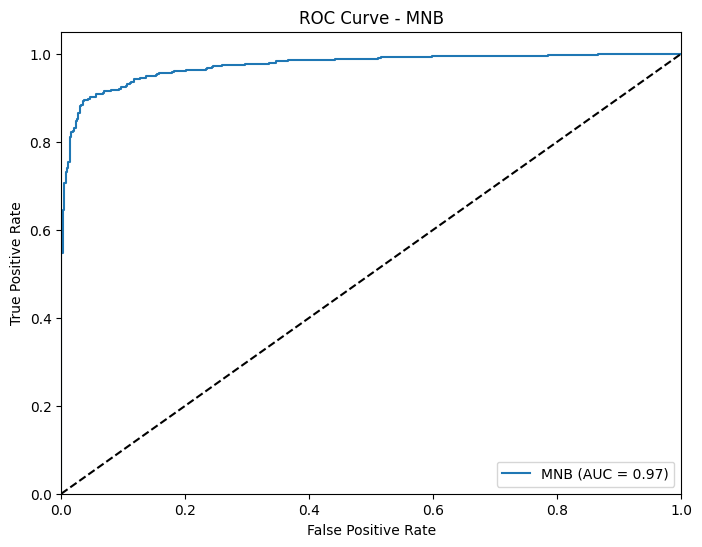

Metrics for LR:
Accuracy: 0.9341801385681293
Precision: 0.9607843137254902
Recall: 0.9053117782909931
F1 Score: 0.9322235434007135
AUC: 0.9839723930470587
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       433
           1       0.96      0.91      0.93       433

    accuracy                           0.93       866
   macro avg       0.94      0.93      0.93       866
weighted avg       0.94      0.93      0.93       866



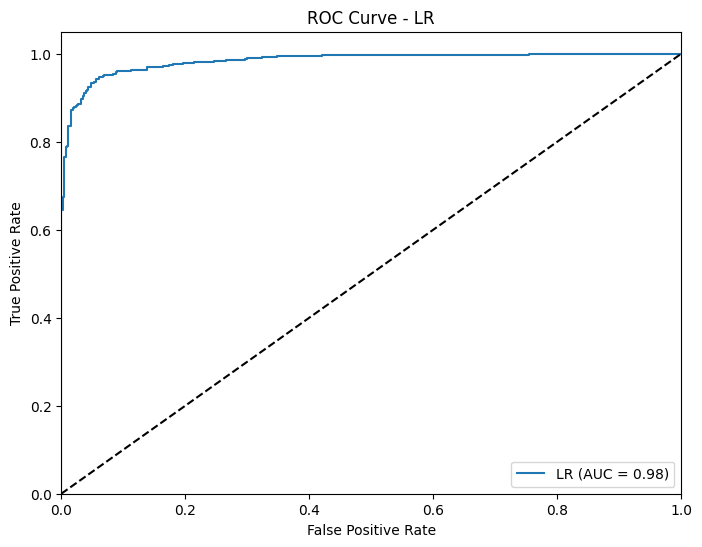

Metrics for RF:
Accuracy: 0.9376443418013857
Precision: 0.9633251833740831
Recall: 0.9099307159353349
F1 Score: 0.9358669833729216
AUC: 0.9836817093269472
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       433
           1       0.96      0.91      0.94       433

    accuracy                           0.94       866
   macro avg       0.94      0.94      0.94       866
weighted avg       0.94      0.94      0.94       866



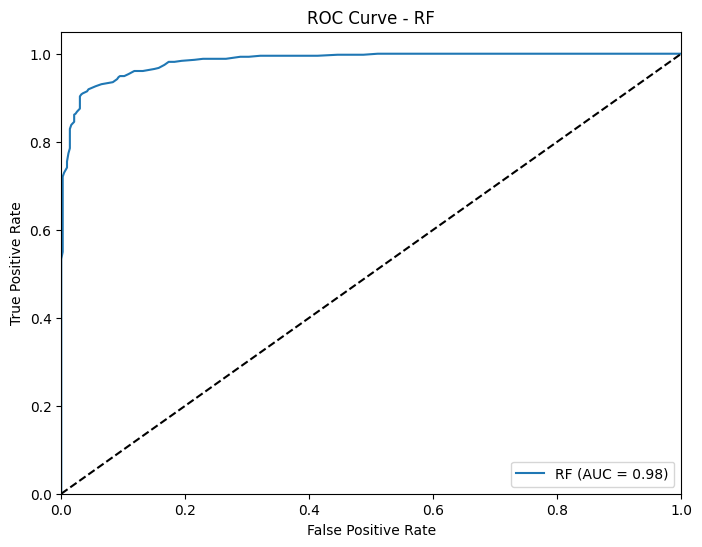

Metrics for KNN:
Accuracy: 0.851039260969977
Precision: 0.8003952569169961
Recall: 0.9353348729792148
F1 Score: 0.8626198083067093
AUC: 0.9453834624964665
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       433
           1       0.80      0.94      0.86       433

    accuracy                           0.85       866
   macro avg       0.86      0.85      0.85       866
weighted avg       0.86      0.85      0.85       866



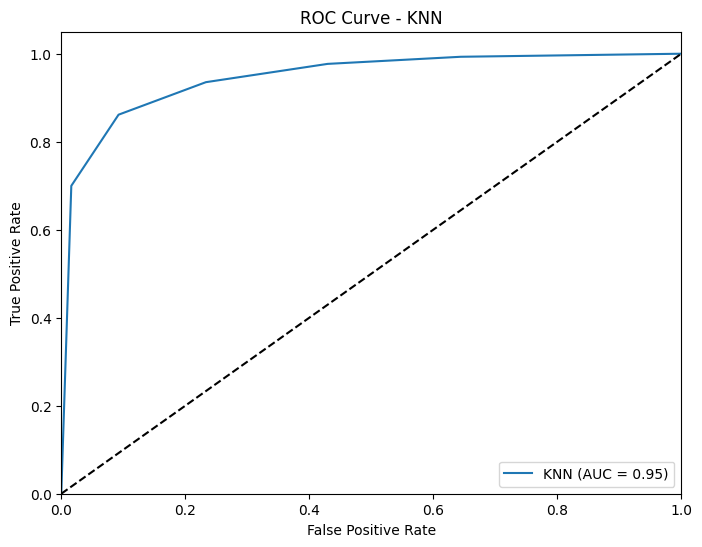

Metrics for SVM:
Accuracy: 0.9434180138568129
Precision: 0.9729064039408867
Recall: 0.9122401847575058
F1 Score: 0.9415971394517283
AUC: 0.9888206774797454
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       433
           1       0.97      0.91      0.94       433

    accuracy                           0.94       866
   macro avg       0.95      0.94      0.94       866
weighted avg       0.95      0.94      0.94       866



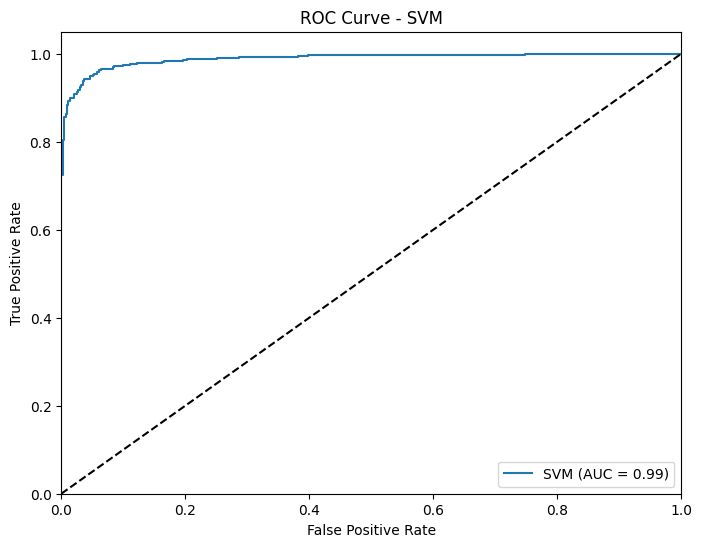

In [12]:


# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Use TFIDF inside of stacking to vectorize X_val(Evaluation)
vectorized_text = stack.named_steps['vectorizer'].transform(X_val)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9561200923787528
Precision: 0.9603729603729604
Recall: 0.9515011547344111
F1 Score: 0.9559164733178654
AUC: 0.9908101275274817
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       433
           1       0.96      0.95      0.96       433

    accuracy                           0.96       866
   macro avg       0.96      0.96      0.96       866
weighted avg       0.96      0.96      0.96       866



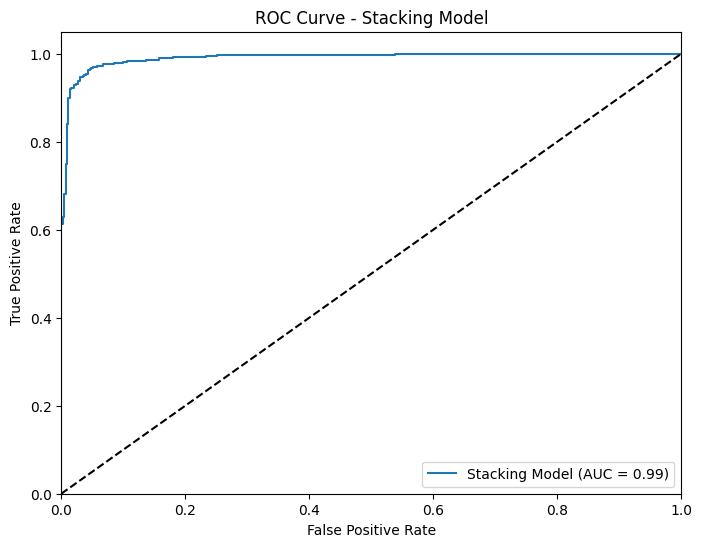

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.841801  0.770073  0.974596  0.860347  0.973497
LR               0.93418  0.960784  0.905312  0.932224  0.983972
RF              0.937644  0.963325  0.909931  0.935867  0.983682
KNN             0.851039  0.800395  0.935335   0.86262  0.945383
SVM             0.943418  0.972906   0.91224  0.941597  0.988821
Stacking Model   0.95612  0.960373  0.951501  0.955916   0.99081


In [13]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val)
stack_y_prob = stack.predict_proba(X_val)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [14]:
# Save the model using joblib
joblib.dump(stack, '../../Models/70-30 Test/pipeline_lr_2.joblib')

['../../Models/70-30 Test/pipeline_lr_2.joblib']